In [1]:
import pandas as pd
import numpy as np
import pandas_datareader as web
import time
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [29]:
#此區塊為macd的strategy & paper 的strategy處理
data_tw = pd.read_csv('D:\stock_papper\stock_label.csv', index_col = 'Date')
data_tw.index = pd.to_datetime(data_tw.index, format = '%Y/%m/%d')
data_tw['3ma'] = data_tw['Adj Close'].ewm(span = 3).mean()
data_tw['11ma'] = data_tw['Adj Close'].ewm(span = 11).mean()
data_tw['3-11MACD'] = data_tw['3ma'] - data_tw['11ma']
data_tw['MACD_6'] = data_tw['3-11MACD'].ewm(span = 6).mean()
data_tw['log_return'] = np.log(data_tw['Adj Close'].values) - np.log(data_tw['Adj Close'].shift(1).values)
data_tw = data_tw.dropna()

data_tw['strategy'] = data_tw['3-11MACD'] - data_tw['MACD_6']
data_tw['signal'] = 0
for i in range(data_tw.shape[0]):
    if data_tw.iloc[i, 7] > 0:
        data_tw.iloc[i, 8] = 1
    elif data_tw.iloc[i, 7] < 0:
        data_tw.iloc[i, 8] = -1
        
count = 0
while count < data_tw.shape[0]:
    tmp = data_tw.iloc[count, 8];
    for i in range(count + 1, data_tw.shape[0], 1):
        if tmp == data_tw.iloc[i, 8]:
            data_tw.iloc[i, 8] = 0
        else :
            count = i - 1
            break
    count += 1
    
#實作出paper的ANN model
x, y = [], []
for i in range(36, data_tw.shape[0] - 800):
    tmp_y = data_tw.iloc[i, 0]
    y.append(tmp_y)
    tmp_x = data_tw.iloc[i- 36:i- 12, 0]
    x.append(tmp_x)
x, y = np.array(x), np.array(y)

x_test, y_test = [], []
for i in range(data_tw.shape[0] - 800, data_tw.shape[0]):
    tmp_x = data_tw.iloc[i - 36:i - 12, 0]
    x_test.append(tmp_x)
    tmp_y = data_tw.iloc[i, 0]
    y_test.append(tmp_y)
    
y_all = np.concatenate((y, y_test), axis = 0)

#ANN model訓練並且預測concat回data中
ann_regr = MLPRegressor(hidden_layer_sizes=(8), alpha = 0.01, max_iter= 500)
ann_regr.fit(x, y)
y_predict = ann_regr.predict(x_test)

#蒐集2017年度以後的data
data = data_tw.iloc[-1194:, :]
data_for_predict = data_tw.iloc[-1230:, ]

predict_data = []
for i in range(36, data_for_predict.shape[0]):
    predict_data.append(data_for_predict.iloc[i - 36:i - 12, 0])
predict_data = np.array(predict_data)
y_predict = ann_regr.predict(predict_data)
data['ann_12_after'] = y_predict

data['ann_signal'] = 0
for i in range(data.shape[0]):
    if data.iloc[i, 9] - data.iloc[i, 0] > 0:
        data.iloc[i, 10] = 1
    elif data.iloc[i, 9] - data.iloc[i, 0] < 0:
        data.iloc[i, 10] = -1
        
data_2017 = data.iloc[:243]
data_2018 = data.iloc[244:488]
data_2019 = data.iloc[489:729]
data_2020 = data.iloc[730: 974]
data_2021 = data.iloc[975:]

#實作自己預測反轉點的model，整理vix指數、oil指數、gold指數和usd_bond指數
target_vix = '%5EVIX'
start = dt.datetime(2005, 1, 1)
end = dt.date(2021, 11, 1)
data_vix = web.DataReader(target_vix, 'yahoo', start, end)
data_vix['log_return'] = (np.log(data_vix.Close.values) - np.log(data_vix.Close.shift(1).values))

#把加權指數的data讀近來，並進行整理
data_tw = pd.read_csv('D:\stock_papper\stock_label.csv', index_col = 'Date')
data_tw.index = pd.to_datetime(data_tw.index, format = '%Y/%m/%d')
data_tw['3ma'] = data_tw['Adj Close'].ewm(span = 3).mean()
data_tw['11ma'] = data_tw['Adj Close'].ewm(span = 11).mean()
data_tw['3-11MACD'] = data_tw['3ma'] - data_tw['11ma']
data_tw['3_6_11strategy'] = data_tw['3-11MACD'].ewm(span = 6).mean()
data_tw['log_return'] = np.log(data_tw['Adj Close'].values) - np.log(data_tw['Adj Close'].shift(1).values)
data_tw = data_tw.dropna()

data_merge = pd.merge(data_tw.iloc[:, [0, 1, 4, 5, 6]], data_vix.iloc[:, 6], how = 'inner', left_index = True, right_index = True)
data_merge = data_merge.rename(columns = {'log_return_x': 'index_log_return', 'log_return_y': 'vix_log_return'})

#整理other index的data
wti_oil_data = pd.read_csv('D:\stock_papper\wti_oil_data.csv')
wti_oil_data = wti_oil_data.rename(columns = {'日期': 'Date', '收市': 'Close', '開市': 'Open', '高': 'High', '低': 'Low', '成交量': 'Volume', '更改%': 'Percentage change'})
wti_oil_data = wti_oil_data.set_index('Date')
wti_oil_data.index = pd.to_datetime(wti_oil_data.index, format = '%Y年%m月%d日')
wti_oil_data = wti_oil_data.iloc[::-1, :]
wti_oil_data = wti_oil_data.drop(columns = ['Volume', 'Percentage change'])
wti_oil_data['daily_return'] = (wti_oil_data.Close - wti_oil_data.Close.shift(1))/ wti_oil_data.Close.shift(1)
wti_oil_data['log_return'] = np.log(wti_oil_data.Close.values) - np.log(wti_oil_data.Close.shift(1).values)
wti_oil_data['max_min'] = (wti_oil_data.Close - wti_oil_data.Close.min())/ (wti_oil_data.Close.max() - wti_oil_data.Close.min())
wti_oil_data['high_low'] = (wti_oil_data.High - wti_oil_data.Low)/ wti_oil_data.Low
wti_oil_data = wti_oil_data.dropna()

gold_data = pd.read_csv("D:\stock_papper\gold_data.csv")
gold_data = gold_data.rename(columns = {'日期': 'Date', '收市': 'Close', '開市': 'Open', '高': 'High', '低': 'Low', '成交量': 'Volume', '更改%': 'Percentage change'})
gold_data = gold_data.set_index('Date')
gold_data.index = pd.to_datetime(gold_data.index, format = '%Y/%m/%d')
gold_data = gold_data.iloc[::-1, :]
gold_data = gold_data.drop(columns = ['Volume', 'Percentage change'])
change = ['Close', 'Open', 'High', 'Low']
for i in change:
    gold_data[i] = gold_data[i].str.replace(',', '').astype(float)
gold_data['daily_return'] = (gold_data.Close - gold_data.Close.shift(1))/ gold_data.Close.shift(1)
gold_data['log_return'] = np.log(gold_data.Close.values) - np.log(gold_data.Close.shift(1).values)
gold_data['max_min'] = (gold_data.Close - gold_data.Close.min())/ (gold_data.Close.max() - gold_data.Close.min())
gold_data['high_low'] = (gold_data.High - gold_data.Low)/ gold_data.Low
gold_data = gold_data.dropna()

usd_bond = pd.read_csv('D:/stock_papper/10y_usd_bond_data.csv')
usd_bond = usd_bond.rename(columns = {'日期': 'Date', '收市': 'Close', '開市': 'Open', '高': 'High', '低': 'Low', '成交量': 'Volume', '更改%': 'Percentage change'})
usd_bond = usd_bond.set_index('Date')
usd_bond.index = pd.to_datetime(usd_bond.index, format = '%Y年%m月%d日')
usd_bond = usd_bond.iloc[::-1, :]
usd_bond = usd_bond.drop(columns = ['Volume', 'Percentage change'])
usd_bond['daily_return'] = (usd_bond.Close - usd_bond.Close.shift(1))/ usd_bond.Close.shift(1)
usd_bond['log_return'] = np.log(usd_bond.Close.values) - np.log(usd_bond.Close.shift(1).values)
usd_bond['max_min'] = (usd_bond.Close - usd_bond.Close.min())/ (usd_bond.Close.max() - usd_bond.Close.min())
usd_bond['high_low'] = (usd_bond.High - usd_bond.Low)/ usd_bond.Low
usd_bond = usd_bond.dropna()

#將oil、gold和bond的資料和在一起
data_other_index = pd.merge(gold_data.iloc[:, 5], wti_oil_data.iloc[:, 5], how = 'inner', left_index = True, right_index = True)
data_other_index = pd.merge(data_other_index, usd_bond.iloc[:, 5], how = 'inner', left_index = True, right_index = True)

#data_merge_all = 所有的data的加總
data_merge_all = pd.merge(data_merge, data_other_index, how = 'inner', left_index = True, right_index = True)
#data_mask = 標記為反轉點的data
data_mask = data_merge_all[(data_merge_all['label'] == 1) | (data_merge_all['label'] == -1)]

    
#取出各年度label為0的data訓練模型
#2017
data_for_2017 = data_merge_all.iloc[-1200:-1141, :]
data_training_2017 = pd.concat([data_mask, data_for_2017], axis = 0)
data_training_2017 = data_training_2017.dropna()
x_train_2017, y_train_2017 = data_training_2017.iloc[:, [2, 3, 4, 5, 6, 7, 8]], data_training_2017.iloc[:, 1]
x_train_split_2017, x_test_split_2017, y_train_split_2017, y_test_split_2017 = train_test_split(x_train_2017, y_train_2017, test_size = 0.2)
clf_random_2017 = RandomForestClassifier(n_estimators=450)
clf_random_2017.fit(x_train_split_2017, y_train_split_2017)
y_predict_2017 = clf_random_2017.predict(x_test_split_2017)
print(accuracy_score(y_test_split_2017, y_predict_2017))

#2018
data_for_2018 = data_merge_all.iloc[-1000:-903, :]
data_training_2018 = pd.concat([data_mask, data_for_2018], axis = 0)
data_training_2018 = data_training_2018.dropna()
x_train_2018, y_train_2018 = data_training_2018.iloc[:, [2, 3, 4, 5, 6, 7, 8]], data_training_2018.iloc[:, 1]
x_train_split_2018, x_test_split_2018, y_train_split_2018, y_test_split_2018 = train_test_split(x_train_2018, y_train_2018, test_size = 0.2)
clf_random_2018 = RandomForestClassifier(n_estimators=450)
clf_random_2018.fit(x_train_split_2018, y_train_split_2018)
y_predict_2018 = clf_random_2018.predict(x_test_split_2018)
print(accuracy_score(y_test_split_2018, y_predict_2018))

#2019
data_for_2019 = data_merge_all.iloc[-736:-666, :]
data_training_2019 = pd.concat([data_mask, data_for_2019], axis = 0)
data_training_2019 = data_training_2019.dropna()
x_train_2019, y_train_2019 = data_training_2019.iloc[:, [2, 3, 4, 5, 6, 7, 8]], data_training_2019.iloc[:, 1]
x_train_split_2019, x_test_split_2019, y_train_split_2019, y_test_split_2019 = train_test_split(x_train_2019, y_train_2019, test_size = 0.2)
clf_random_2019 = RandomForestClassifier(n_estimators=450)
clf_random_2019.fit(x_train_split_2019, y_train_split_2019)
y_predict_2019 = clf_random_2019.predict(x_test_split_2019)
print(accuracy_score(y_test_split_2019, y_predict_2019))

#2020
data_for_2020 = data_merge_all.iloc[-500:-433, :]
data_training_2020 = pd.concat([data_mask, data_for_2020], axis = 0)
data_training_2020 = data_training_2020.dropna()
x_train_2020, y_train_2020 = data_training_2020.iloc[:, [2, 3, 4, 5, 6, 7, 8]], data_training_2020.iloc[:, 1]
x_train_split_2020, x_test_split_2020, y_train_split_2020, y_test_split_2020 = train_test_split(x_train_2020, y_train_2020, test_size = 0.2)
clf_random_2020 = RandomForestClassifier(n_estimators=450)
clf_random_2020.fit(x_train_split_2020, y_train_split_2020)
y_predict_2020 = clf_random_2020.predict(x_test_split_2020)
print(accuracy_score(y_test_split_2020, y_predict_2020))

sgd_clf = SGDClassifier(loss="hinge", penalty="l2", max_iter=10)
tree_clf = tree.DecisionTreeClassifier()
clf_random = RandomForestClassifier(n_estimators=200)
xgbc = XGBClassifier()
gnb = GaussianNB()
knn = KNeighborsClassifier(n_neighbors= 15)

model = [sgd_clf, tree_clf, clf_random, gnb, knn]
model_list = ['sgd_clf', 'tree_clf', 'clf_random', 'gnb','knn']

for i in range(0, 5):
    scores = cross_val_score(model[i], x_train_split_2020, y_train_split_2020, cv = 5).mean()
    print(f'{model[i]} : {scores}')

C:\Users\LEGION~1\AppData\Local\Temp/ipykernel_6276/3609136042.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['ann_12_after'] = y_predict
C:\Users\LEGION~1\AppData\Local\Temp/ipykernel_6276/3609136042.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['ann_signal'] = 0
c:\python\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

0.8461538461538461
0.8333333333333334
0.6666666666666666
0.7962962962962963
SGDClassifier(max_iter=10) : 0.7044296788482836
DecisionTreeClassifier() : 0.7086378737541528


c:\python\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\python\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\python\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\python\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\python\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iter

RandomForestClassifier(n_estimators=200) : 0.7325581395348838
GaussianNB() : 0.6944629014396455
KNeighborsClassifier(n_neighbors=15) : 0.7135105204872648


In [39]:
sgd_clf = SGDClassifier(loss="hinge", penalty="l2", max_iter=10)
tree_clf = tree.DecisionTreeClassifier()
clf_random = RandomForestClassifier(n_estimators=400)
xgbc = XGBClassifier()
gnb = GaussianNB()
knn = KNeighborsClassifier(n_neighbors= 15)

data_train = pd.concat([data_mask, data_merge_all.iloc[-400:-200, :]], axis = 0)
x_train, y_train = data_train.iloc[:, [2, 3, 4, 5, 6, 7, 8]], data_train.iloc[:, 1]
model = [sgd_clf, tree_clf, clf_random, gnb, knn]
model_list = ['sgd_clf', 'tree_clf', 'clf_random', 'gnb','knn']

for i in range(0, 5):
    scores = cross_val_score(model[i], x_train, y_train, cv = 5).mean()
    print(f'{model[i]} : {scores}')

c:\python\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\python\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\python\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\python\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\python\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iter

SGDClassifier(max_iter=10) : 0.6275
DecisionTreeClassifier() : 0.645
RandomForestClassifier(n_estimators=400) : 0.6925
GaussianNB() : 0.61
KNeighborsClassifier(n_neighbors=15) : 0.6775


In [3]:
def macd_count(x):
    money = 100
    index = 0
    strategy = 0
    drawdown = 100
    while index < x.shape[0]:
        tmp = x.iloc[index, 8]
        if tmp == 1:
            if strategy == 0:
                strategy = 1
                price = x.iloc[index, 0]
            elif strategy == -1:
                strategy = 0
                money *= ((x.iloc[index, 0] - price)/ price + 1)
                price = 0
            if drawdown > money:
                drawdown = money
        elif tmp == -1:
            if strategy == 1:
                strategy = 0
                money *= ((x.iloc[index, 0] - price)/ price + 1)
                price = 0
            elif strategy == 0:
                strategy = -1
                price = x.iloc[index, 0]
            if drawdown > money:
                drawdown = money
        index += 1
    print(f'MACD strategy : {money}')
    print(f'MACD drawdown : {drawdown}')

In [4]:
def paper_count(x):
    money = 100
    index = 0
    strategy = 0
    drawdown = 100    
    while index < x.shape[0]:
        tmp = x.iloc[index, 8]
        mask = x.iloc[index, 10]
        if tmp == 1 and mask == 1:
            if strategy == 0:
                strategy = 1
                price = x.iloc[index, 0]
            elif strategy == -1:
                strategy = 0
                money *= ((x.iloc[index, 0] - price)/ price + 1)
                price = 0
            if drawdown > money:
                drawdown = money
        elif tmp == -1 and mask == -1:
            if strategy == 1:
                strategy = 0
                money *= ((x.iloc[index, 0] - price)/ price + 1)
                price = 0
            elif strategy == 0:
                strategy = -1
                price = x.iloc[index, 0]
            if drawdown > money:
                drawdown = money                
        index += 1
    print(f'Paper strategy : {money}')
    print(f'Paper drawdown : {drawdown}')
    

In [5]:
def my_strategy_count(x):
    money = 100
    index = 0
    strategy = 0
    drawdown = 100    
    mask_b_1 = 0
    mask_b_2 = 0
    while index < x.shape[0]:
        tmp = x.iloc[index, 8]
        mask = x.iloc[index, 15]
        if index > 1:
            mask_b_1 = x.iloc[index - 1, 15]
        if index < x.shape[0] -1:
            mask_a_1 = x.iloc[index + 1, 15]
        else:
            mask_a_1 = 0
        if tmp == 1 and mask != -1 and mask_b_1 != -1 and mask_a_1 != -1:
            if strategy == 0:
                strategy = 1
                price = x.iloc[index, 0]
            elif strategy == -1:
                strategy = 0
                money *= ((x.iloc[index, 0] - price)/ price + 1)
                price = 0
            if drawdown > money:
                drawdown = money                
        elif tmp == -1 and mask != 1 and mask_b_1 != 1 and mask_a_1 != 1:
            if strategy == 1:
                strategy = 0
                money *= ((x.iloc[index, 0] - price)/ price + 1)
                price = 0
            elif strategy == 0:
                strategy = -1
                price = x.iloc[index, 0]
            if drawdown > money:
                drawdown = money                
        index += 1
    print(f'My strategy : {money}')
    print(f'My strategy drawdown : {drawdown}')

In [6]:
data_2017 = pd.merge(data_2017, data_vix.iloc[:, 6], how = 'inner', left_index = True, right_index = True)
data_2017 = pd.merge(data_2017, data_other_index, how = 'inner', left_index = True, right_index = True)
x_2017 = data_2017.iloc[:, [4, 5, 6, 11, 12, 13, 14]].values
y_2017 = clf_random_2017.predict(x_2017)
data_2017['my_strategy'] = y_2017
data_2017.head()

c:\python\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


,Adj Close,label,3ma,11ma,3-11MACD,MACD_6,log_return_x_x,strategy,signal,ann_12_after,ann_signal,log_return_y_x,log_return_x_y,log_return_y_y,log_return,my_strategy
Date,,,,,,,,,,,,,,,,
2017-01-03,9272.873047,0,9238.673104,9208.431998,30.241106,-12.467258,0.002092,42.708364,0,9369.590236,1,-0.088567,0.078220,0.026483,0.000564,0
2017-01-04,9286.953125,0,9262.813114,9221.518853,41.294262,2.893176,0.001517,38.401086,0,9434.448298,1,-0.081016,0.001926,0.020516,0.000000,0
2017-01-05,9358.132813,0,9310.472964,9244.287846,66.185118,20.976588,0.007635,45.208530,0,9387.381099,1,-0.015306,0.011956,0.010015,0.005785,-1
2017-01-06,9372.212891,0,9341.342927,9265.608687,75.734241,36.621632,0.001503,39.112609,0,9349.730953,-1,-0.030450,-0.005084,0.002445,-0.003370,-1
2017-01-09,9342.413086,0,9341.878007,9278.409420,63.468587,44.292190,-0.003185,19.176397,0,9373.534659,1,0.020980,0.009432,-0.019192,0.002970,0


MACD strategy : 105.77799064943488
MACD drawdown : 100
Paper strategy : 107.90945707146155
Paper drawdown : 100
My strategy : 112.00372306145513
My strategy drawdown : 100


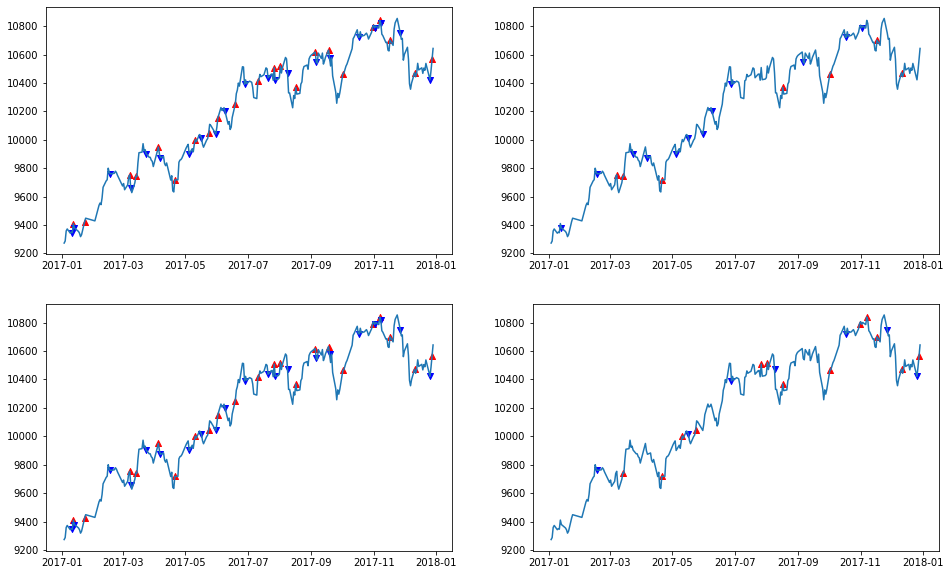

In [7]:
buy = data_2017['signal'] == 1
sell = data_2017['signal'] == -1
buy_up_trend = (data_2017['signal'] == 1) & (data_2017['ann_signal'] == 1)
sell_down_trend = (data_2017['signal'] == -1) & (data_2017['ann_signal'] == -1)
buy_my_strategy = (data_2017['signal'] == 1) & (data_2017['my_strategy'] != -1)
sell_my_strategy = (data_2017['signal'] == -1) & (data_2017['my_strategy'] != 0)

plt.figure(figsize = (16, 10)).subplots(2, 2)
plt.subplot(2, 2, 1)
plt.plot(data_2017['Adj Close'])
plt.scatter(x = data_2017[buy].index, y = np.array((data_2017[buy])['Adj Close']), marker = '^', color = 'red')
plt.scatter(x = data_2017[sell].index, y = np.array((data_2017[sell])['Adj Close']), marker = 'v', color = 'blue')
macd_count(data_2017)

plt.subplot(2, 2, 2)
plt.plot(data_2017['Adj Close'])
plt.scatter(x = data_2017[buy_up_trend].index, y = np.array((data_2017[buy_up_trend])['Adj Close']), marker = '^', color = 'red')
plt.scatter(x = data_2017[sell_down_trend].index, y = np.array((data_2017[sell_down_trend])['Adj Close']), marker = 'v', color = 'blue')
paper_count(data_2017)

plt.subplot(2, 2, 3)
plt.plot(data_2017['Adj Close'])
plt.scatter(x = data_2017[buy].index, y = np.array((data_2017[buy])['Adj Close']), marker = '^', color = 'red')
plt.scatter(x = data_2017[sell].index, y = np.array((data_2017[sell])['Adj Close']), marker = 'v', color = 'blue')

plt.subplot(2, 2, 4)
plt.plot(data_2017['Adj Close'])
plt.scatter(x = data_2017[buy_my_strategy].index, y = np.array((data_2017[buy_my_strategy])['Adj Close']), marker = '^', color = 'red')
plt.scatter(x = data_2017[sell_my_strategy].index, y = np.array((data_2017[sell_my_strategy])['Adj Close']), marker = 'v', color = 'blue')
my_strategy_count(data_2017)
plt.show()

c:\python\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


MACD strategy : 94.97053947840193
MACD drawdown : 94.3154949062114
Paper strategy : 102.96609394910102
Paper drawdown : 98.92301318036154
My strategy : 92.05596893518593
My strategy drawdown : 92.05596893518593


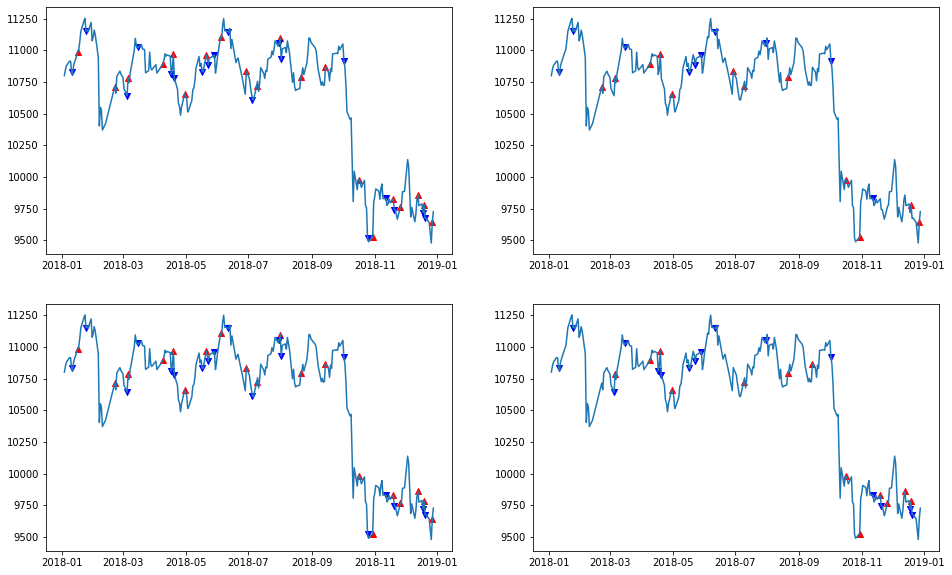

In [8]:
data_2018 = pd.merge(data_2018, data_vix.iloc[:, 6], how = 'inner', left_index = True, right_index = True)
data_2018 = pd.merge(data_2018, data_other_index, how = 'inner', left_index = True, right_index = True)
x_2018 = data_2018.iloc[:, [4, 5, 6, 11, 12, 13, 14]].values
y_2018 = clf_random_2018.predict(x_2018)
data_2018['my_strategy'] = y_2018

buy = data_2018['signal'] == 1
sell = data_2018['signal'] == -1
buy_up_trend = (data_2018['signal'] == 1) & (data_2018['ann_signal'] == 1)
sell_down_trend = (data_2018['signal'] == -1) & (data_2018['ann_signal'] == -1)
buy_my_strategy = (data_2018['signal'] == 1) & (data_2018['my_strategy'] != -1)
sell_my_strategy = (data_2018['signal'] == -1) & (data_2018['my_strategy'] != 1)

plt.figure(figsize = (16, 10)).subplots(2, 2)
plt.subplot(2, 2, 1)
plt.plot(data_2018['Adj Close'])
plt.scatter(x = data_2018[buy].index, y = np.array((data_2018[buy])['Adj Close']), marker = '^', color = 'red')
plt.scatter(x = data_2018[sell].index, y = np.array((data_2018[sell])['Adj Close']), marker = 'v', color = 'blue')
macd_count(data_2018)

plt.subplot(2, 2, 2)
plt.plot(data_2018['Adj Close'])
plt.scatter(x = data_2018[buy_up_trend].index, y = np.array((data_2018[buy_up_trend])['Adj Close']), marker = '^', color = 'red')
plt.scatter(x = data_2018[sell_down_trend].index, y = np.array((data_2018[sell_down_trend])['Adj Close']), marker = 'v', color = 'blue')
paper_count(data_2018)

plt.subplot(2, 2, 3)
plt.plot(data_2018['Adj Close'])
plt.scatter(x = data_2018[buy].index, y = np.array((data_2018[buy])['Adj Close']), marker = '^', color = 'red')
plt.scatter(x = data_2018[sell].index, y = np.array((data_2018[sell])['Adj Close']), marker = 'v', color = 'blue')

plt.subplot(2, 2, 4)
plt.plot(data_2018['Adj Close'])
plt.scatter(x = data_2018[buy_my_strategy].index, y = np.array((data_2018[buy_my_strategy])['Adj Close']), marker = '^', color = 'red')
plt.scatter(x = data_2018[sell_my_strategy].index, y = np.array((data_2018[sell_my_strategy])['Adj Close']), marker = 'v', color = 'blue')
my_strategy_count(data_2018)
plt.show()

In [9]:
data_2019 = pd.merge(data_2019, data_vix.iloc[:, 6], how = 'inner', left_index = True, right_index = True)
data_2019 = pd.merge(data_2019, data_other_index, how = 'inner', left_index = True, right_index = True)
x_2019 = data_2019.iloc[:, [4, 5, 6, 11, 12, 13, 14]].values
y_2019 = clf_random_2019.predict(x_2019)
data_2019['my_strategy'] = y_2019

c:\python\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


MACD strategy : 110.94665121330692
MACD drawdown : 100
Paper strate
My strategy : 107.64183879377333
My strategy drawdown : 100


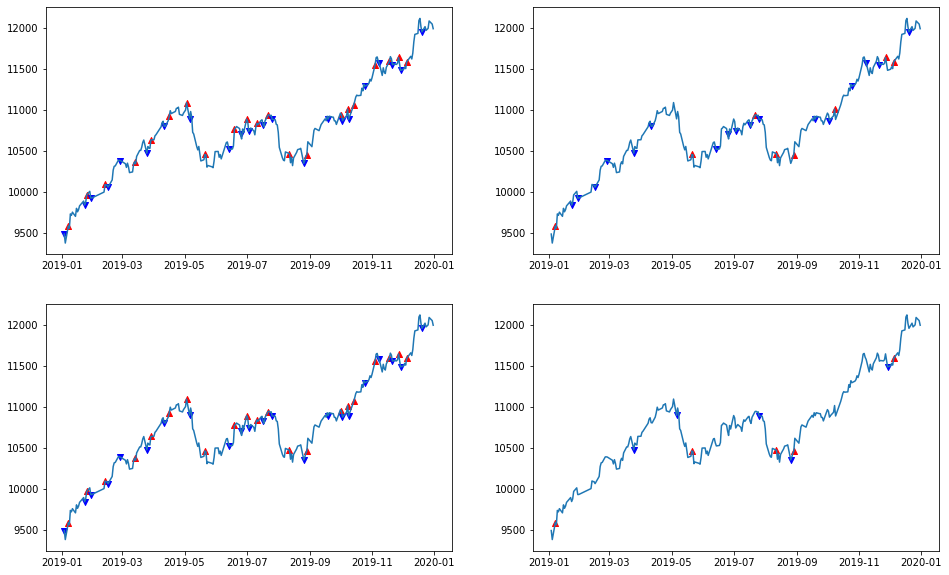

In [18]:
buy = data_2019['signal'] == 1
sell = data_2019['signal'] == -1
buy_up_trend = (data_2019['signal'] == 1) & (data_2019['ann_signal'] == 1)
sell_down_trend = (data_2019['signal'] == -1) & (data_2019['ann_signal'] == -1)
buy_my_strategy = (data_2019['signal'] == 1) & (data_2019['my_strategy'] != -1)
sell_my_strategy = (data_2019['signal'] == -1) & (data_2019['my_strategy'] == 0)

plt.figure(figsize = (16, 10)).subplots(2, 2)
plt.subplot(2, 2, 1)
plt.plot(data_2019['Adj Close'])
plt.scatter(x = data_2019[buy].index, y = np.array((data_2019[buy])['Adj Close']), marker = '^', color = 'red')
plt.scatter(x = data_2019[sell].index, y = np.array((data_2019[sell])['Adj Close']), marker = 'v', color = 'blue')
macd_count(data_2019)

plt.subplot(2, 2, 2)
plt.plot(data_2019['Adj Close'])
plt.scatter(x = data_2019[buy_up_trend].index, y = np.array((data_2019[buy_up_trend])['Adj Close']), marker = '^', color = 'red')
plt.scatter(x = data_2019[sell_down_trend].index, y = np.array((data_2019[sell_down_trend])['Adj Close']), marker = 'v', color = 'blue')
paper_count

plt.subplot(2, 2, 3)
plt.plot(data_2019['Adj Close'])
plt.scatter(x = data_2019[buy].index, y = np.array((data_2019[buy])['Adj Close']), marker = '^', color = 'red')
plt.scatter(x = data_2019[sell].index, y = np.array((data_2019[sell])['Adj Close']), marker = 'v', color = 'blue')

plt.subplot(2, 2, 4)
plt.plot(data_2019['Adj Close'])
plt.scatter(x = data_2019[buy_my_strategy].index, y = np.array((data_2019[buy_my_strategy])['Adj Close']), marker = '^', color = 'red')
plt.scatter(x = data_2019[sell_my_strategy].index, y = np.array((data_2019[sell_my_strategy])['Adj Close']), marker = 'v', color = 'blue')
my_strategy_count(data_2019)
plt.show()

In [11]:
data_2020 = pd.merge(data_2020, data_vix.iloc[:, 6], how = 'inner', left_index = True, right_index = True)
data_2020 = pd.merge(data_2020, data_other_index, how = 'inner', left_index = True, right_index = True)
x_2020 = data_2020.iloc[:, [4, 5, 6, 11, 12, 13, 14]].values
y_2020 = clf_random_2020.predict(x_2020)
data_2020['my_strategy'] = y_2020

c:\python\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


MACD strategy : 104.77815917989689
MACD drawdown : 82.42581819213648
Paper strategy : 104.42816224966737
Paper drawdown : 85.56107318143825
My strategy : 120.14359229172288
My strategy drawdown : 99.14296199848151


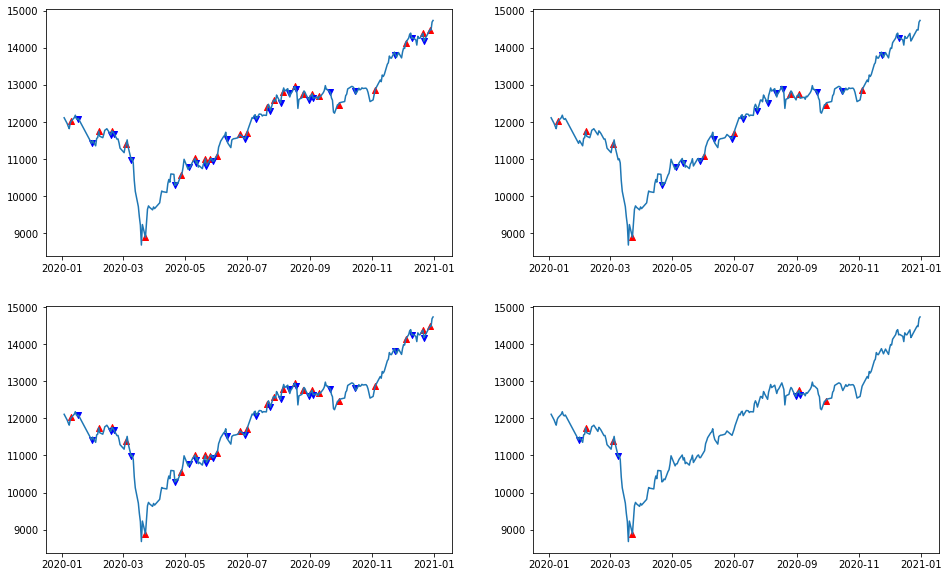

In [12]:
buy = data_2020['signal'] == 1
sell = data_2020['signal'] == -1
buy_up_trend = (data_2020['signal'] == 1) & (data_2020['ann_signal'] == 1)
sell_down_trend = (data_2020['signal'] == -1) & (data_2020['ann_signal'] == -1)
buy_my_strategy = (data_2020['signal'] == 1) & (data_2020['my_strategy'] != -1)
sell_my_strategy = (data_2020['signal'] == -1) & (data_2020['my_strategy'] == 1)

plt.figure(figsize = (16, 10)).subplots(2, 2)
plt.subplot(2, 2, 1)
plt.plot(data_2020['Adj Close'])
plt.scatter(x = data_2020[buy].index, y = np.array((data_2020[buy])['Adj Close']), marker = '^', color = 'red')
plt.scatter(x = data_2020[sell].index, y = np.array((data_2020[sell])['Adj Close']), marker = 'v', color = 'blue')
macd_count(data_2020)

plt.subplot(2, 2, 2)
plt.plot(data_2020['Adj Close'])
plt.scatter(x = data_2020[buy_up_trend].index, y = np.array((data_2020[buy_up_trend])['Adj Close']), marker = '^', color = 'red')
plt.scatter(x = data_2020[sell_down_trend].index, y = np.array((data_2020[sell_down_trend])['Adj Close']), marker = 'v', color = 'blue')
paper_count(data_2020)

plt.subplot(2, 2, 3)
plt.plot(data_2020['Adj Close'])
plt.scatter(x = data_2020[buy].index, y = np.array((data_2020[buy])['Adj Close']), marker = '^', color = 'red')
plt.scatter(x = data_2020[sell].index, y = np.array((data_2020[sell])['Adj Close']), marker = 'v', color = 'blue')

plt.subplot(2, 2, 4)
plt.plot(data_2020['Adj Close'])
plt.scatter(x = data_2020[buy_my_strategy].index, y = np.array((data_2020[buy_my_strategy])['Adj Close']), marker = '^', color = 'red')
plt.scatter(x = data_2020[sell_my_strategy].index, y = np.array((data_2020[sell_my_strategy])['Adj Close']), marker = 'v', color = 'blue')
my_strategy_count(data_2020)
plt.show()

In [13]:
data_2021 = pd.merge(data_2021, data_vix.iloc[:, 6], how = 'inner', left_index = True, right_index = True)
data_2021 = pd.merge(data_2021, data_other_index, how = 'inner', left_index = True, right_index = True)
x_2021 = data_2021.iloc[:, [4, 5, 6, 11, 12, 13, 14]].values
y_2021 = clf_random_2020.predict(x_2021)
data_2021['my_strategy'] = y_2021

c:\python\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


MACD strategy : 98.36850194614638
MACD drawdown : 98.13266005390761
Paper strategy : 114.28212136703038
Paper drawdown : 100
My strategy : 118.02767896136350
My strategy drawdown : 100


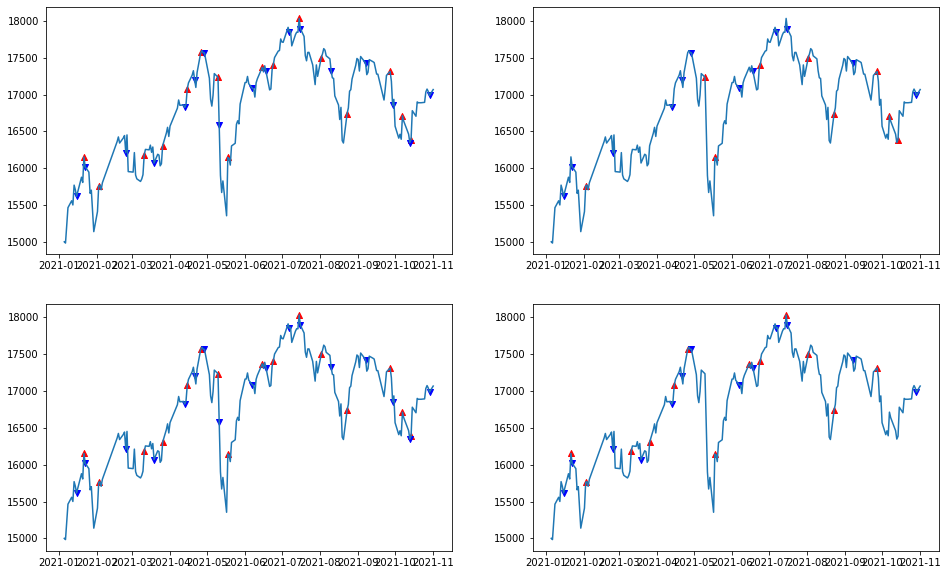

In [16]:
buy = data_2021['signal'] == 1
sell = data_2021['signal'] == -1
buy_up_trend = (data_2021['signal'] == 1) & (data_2021['ann_signal'] == 1)
sell_down_trend = (data_2021['signal'] == -1) & (data_2021['ann_signal'] == -1)
buy_my_strategy = (data_2021['signal'] == 1) & (data_2021['my_strategy'] == -1)
sell_my_strategy = (data_2021['signal'] == -1) & (data_2021['my_strategy'] != 1)

plt.figure(figsize = (16, 10)).subplots(2, 2)
plt.subplot(2, 2, 1)
plt.plot(data_2021['Adj Close'])
plt.scatter(x = data_2021[buy].index, y = np.array((data_2021[buy])['Adj Close']), marker = '^', color = 'red')
plt.scatter(x = data_2021[sell].index, y = np.array((data_2021[sell])['Adj Close']), marker = 'v', color = 'blue')
macd_count(data_2021)

plt.subplot(2, 2, 2)
plt.plot(data_2021['Adj Close'])
plt.scatter(x = data_2021[buy_up_trend].index, y = np.array((data_2021[buy_up_trend])['Adj Close']), marker = '^', color = 'red')
plt.scatter(x = data_2021[sell_down_trend].index, y = np.array((data_2021[sell_down_trend])['Adj Close']), marker = 'v', color = 'blue')
paper_count(data_2021)

plt.subplot(2, 2, 3)
plt.plot(data_2021['Adj Close'])
plt.scatter(x = data_2021[buy].index, y = np.array((data_2021[buy])['Adj Close']), marker = '^', color = 'red')
plt.scatter(x = data_2021[sell].index, y = np.array((data_2021[sell])['Adj Close']), marker = 'v', color = 'blue')

plt.subplot(2, 2, 4)
plt.plot(data_2021['Adj Close'])
plt.scatter(x = data_2021[buy_my_strategy].index, y = np.array((data_2021[buy_my_strategy])['Adj Close']), marker = '^', color = 'red')
plt.scatter(x = data_2021[sell_my_strategy].index, y = np.array((data_2021[sell_my_strategy])['Adj Close']), marker = 'v', color = 'blue')
plt.show()

In [ ]:
mask_2017 = (data_2017['label'] == 1) | (data_2017['label'] == -1)
mask_2018 = (data_2018['label'] == 1) | (data_2018['label'] == -1)
mask_2019 = (data_2019['label'] == 1) | (data_2019['label'] == -1)
mask_2020 = (data_2020['label'] == 1) | (data_2020['label'] == -1)
mask_2021 = (data_2021['label'] == 1) | (data_2021['label'] == -1)

In [ ]:
data_2018[mask_2018]

In [ ]:
data_2019[mask_2019]

In [ ]:
data_2020[mask_2020]

In [ ]:
data_2021[mask_2021]